# Import packages

In [126]:
import os
# import requests
# import networkx as nx
# import pandas as pd
# import geopandas as gpd
# from pyvis.network import Network
# import openai
from IPython.display import display, HTML, Code
from IPython.display import clear_output

In [127]:
# %load_ext autoreload
# %autoreload 2

import LLM_Geo_Constants as constants
import helper
# import LLM_Geo_kernel.Solution as Solution

from LLM_Geo_kernel import Solution

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [128]:
# #Case 1: population living near hazardous wastes

# task_name ='Resident_at_risk_counting'

# TASK = r"""1) Find out the total population that lives within a tract that contain hazardous waste facilities. The study area is North Carolina, US.
# 2) Generate a map to show the spatial distribution of population at the tract level and highlight the borders of tracts that have hazardous waste facilitiesm, also show the facility location.
# """
# DATA_LOCATIONS = ["NC hazardous waste facility ESRI shape file location: https://github.com/gladcolor/LLM- Geo/raw/master/overlay_analysis/Hazardous_Waste_Sites.zip.",
#                   "NC tract boundary shapefile location: https://github.com/gladcolor/LLM-Geo/raw/master/overlay_analysis/tract_shp_37.zip. The tract id column is 'Tract'.",
#                   "NC tract population CSV file location: https://github.com/gladcolor/LLM-Geo/raw/master/overlay_analysis/NC_tract_population.csv. The population is stored in 'TotalPopulation' column. The tract ID column is 'GEOID'."
#                  ]

#Case 2: France_mobility_changes_2020
task_name ='France_mobility_changes_2020'
TASK = r'''
1) Show the 2020 human mobility monthly change rates of each administrative regions in a France choropleth map. Each month is a sub-map in a map matrix，12 months in total. All monthly maps need to use the same colorbar range. The base of the change rate is January 2020. 
2) Draw a line chart to show the monthly change rate trends of all administrative regeions. Each region is a line (the region name is the legend), the x-axis is 2020 months.
'''

DATA_LOCATIONS = ["ESRI shapefile for France administrative regions:" + \
                  "https://github.com/gladcolor/LLM-Geo/raw/master/REST_API/France.zip. " + \
                  "The 'GID_1' column is the administrative region code, 'NAME_1' column is the administrative region name.",
                  "REST API url with parameters for human mobility data access:" + \
                  "http://gis.cas.sc.edu/GeoAnalytics/REST?operation=get_daily_movement_for_all_places&source=twitter&scale=world_first_level_admin&begin=01/01/2020&end=12/31/2020." + \
                  "The response is in CSV format. There are three columns in the response: " + \
                  "place,date (format:2020-01-07), and intra_movement. 'place' column is the administractive region code of every country; codes for France administrative regions start with 'FRA'.",
                 ]


# # Case 3: COVID-19 prevalence trend
# task_name ='COVID_death_rate'
# TASK = r'''1) Draw a map to show the death rate (death/case) of COVID-19 among the countiguous US counties. Use the accumulated COVID-19 data of 2020.12.31 to compute the death rate. Use scheme ='quantiles' when plotting the map.  Set map projection to 'Conus Albers'. Set map size to 15*10 inches.  
# 2) Draw a scatter plot to show the correlation and trend line of the death rate with the senior resident rate, including the r-square and p-value. Set data point transparency to 50%, regression line as red.  Set figure size to 15*10 inches.  
# '''

# DATA_LOCATIONS = [
#                   r"COVID-19 data case in 2020 (county-level): https://github.com/nytimes/covid-19-data/raw/master/us-counties-2020.csv. This data is for daily accumulated COVID cases and deaths for each county in the US. There are 5 columns: date (format: 2021-02-01), county, state, fips, cases, deaths. ",   
#                   r"Contiguous US county boundary (ESRI shapefile): https://github.com/gladcolor/spatial_data/raw/master/contiguous_counties.zip. The county FIPS column is 'GEOID'. ",
#                   r"Census data (ACS2020): https://raw.githubusercontent.com/gladcolor/spatial_data/master/Demography/ACS2020_5year_county.csv. THe needed columns are: 'FIPS', 'Total Population', 'Total Population: 65 to 74 Years', 'Total Population: 75 to 84 Years', 'Total Population: 85 Years and Over'. Drop rows with NaN cells after loading the used columns.",
#                  ]

 

# # # Case 4: Hospital_accessibility
# task_name ='Hospital_accessibility'
# TASK = r'''
# For each zipcode area in South Carolina (SC), calculate the distance from the centroid of the zipcode area to its nearest hospital, and then create a choropleth distance map of zipcode area polygons (unit: km), also show the hospital.
# '''

# DATA_LOCATIONS = [
# r"SC zipcode boundary shapefile: https://github.com/GIBDUSC/test/raw/master/sc_zip_boundary.zip, the map projection is WGS1984.",
# r"SC hospitals:  https://github.com/gladcolor/spatial_data/raw/master/South_Carolina/SC_hospitals_with_emergency_room_cleaned.csv, location columns: longitude in 'POINT_X' column, latitude in 'POINT_Y' column.",          
# ]


  
save_dir = os.path.join(os.getcwd(), task_name)
os.makedirs(save_dir, exist_ok=True)

# create graph
# model=r"gpt-3.5-turbo"
model=r"gpt-4"
solution = Solution(
                    task=TASK,
                    task_name=task_name,
                    save_dir=save_dir,
                    data_locations=DATA_LOCATIONS,
                    model=model,
                    )
print("Prompt to get solution graph:\n")
print(solution.direct_request_prompt)

Prompt to get solution graph:

Your role: A professional Geo-information scientist and developer good at Python. 
Your task: Write a Python program to address the question or task: 
1) Show the 2020 human mobility monthly change rates of each administrative regions in a France choropleth map. Each month is a sub-map in a map matrix，12 months in total. All monthly maps need to use the same colorbar range. The base of the change rate is January 2020. 
2) Draw a line chart to show the monthly change rate trends of all administrative regeions. Each region is a line (the region name is the legend), the x-axis is 2020 months.
 
Location for data you may need: 1. ESRI shapefile for France administrative regions:https://github.com/gladcolor/LLM-Geo/raw/master/REST_API/France.zip. The 'GID_1' column is the administrative region code, 'NAME_1' column is the administrative region name.
2. REST API url with parameters for human mobility data access:http://gis.cas.sc.edu/GeoAnalytics/REST?operation

```python
import geopandas as gpd
import requests
import pandas as pd
import matplotlib.pyplot as plt
from io import StringIO
from mpl_toolkits.axes_grid1 import make_axes_locatable

def direct_solution():
    # Load the France administrative regions shapefile
    FRANCE_SHAPEFILE_URL = "https://github.com/gladcolor/LLM-Geo/raw/master/REST_API/France.zip"
    france_regions = gpd.read_file(FRANCE_SHAPEFILE_URL)

    # Access the human mobility data
    REST_API_URL = "http://gis.cas.sc.edu/GeoAnalytics/REST?operation=get_daily_movement_for_all_places&source=twitter&scale=world_first_level_admin&begin=01/01/2020&end=12/31/2020"
    response = requests.get(REST_API_URL)
    mobility_data_raw = StringIO(response.text)
    mobility_df = pd.read_csv(mobility_data_raw)
    france_mobility_df = mobility_df[mobility_df['place'].str.startswith('FRA')]

    # Preprocess and calculate the monthly change rates
    france_mobility_df['date'] = pd.to_datetime(france_mobility_df['date'])
    france_m

Complete program:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
Complete program:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  def __init__(self,
Complete program:23: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  task,


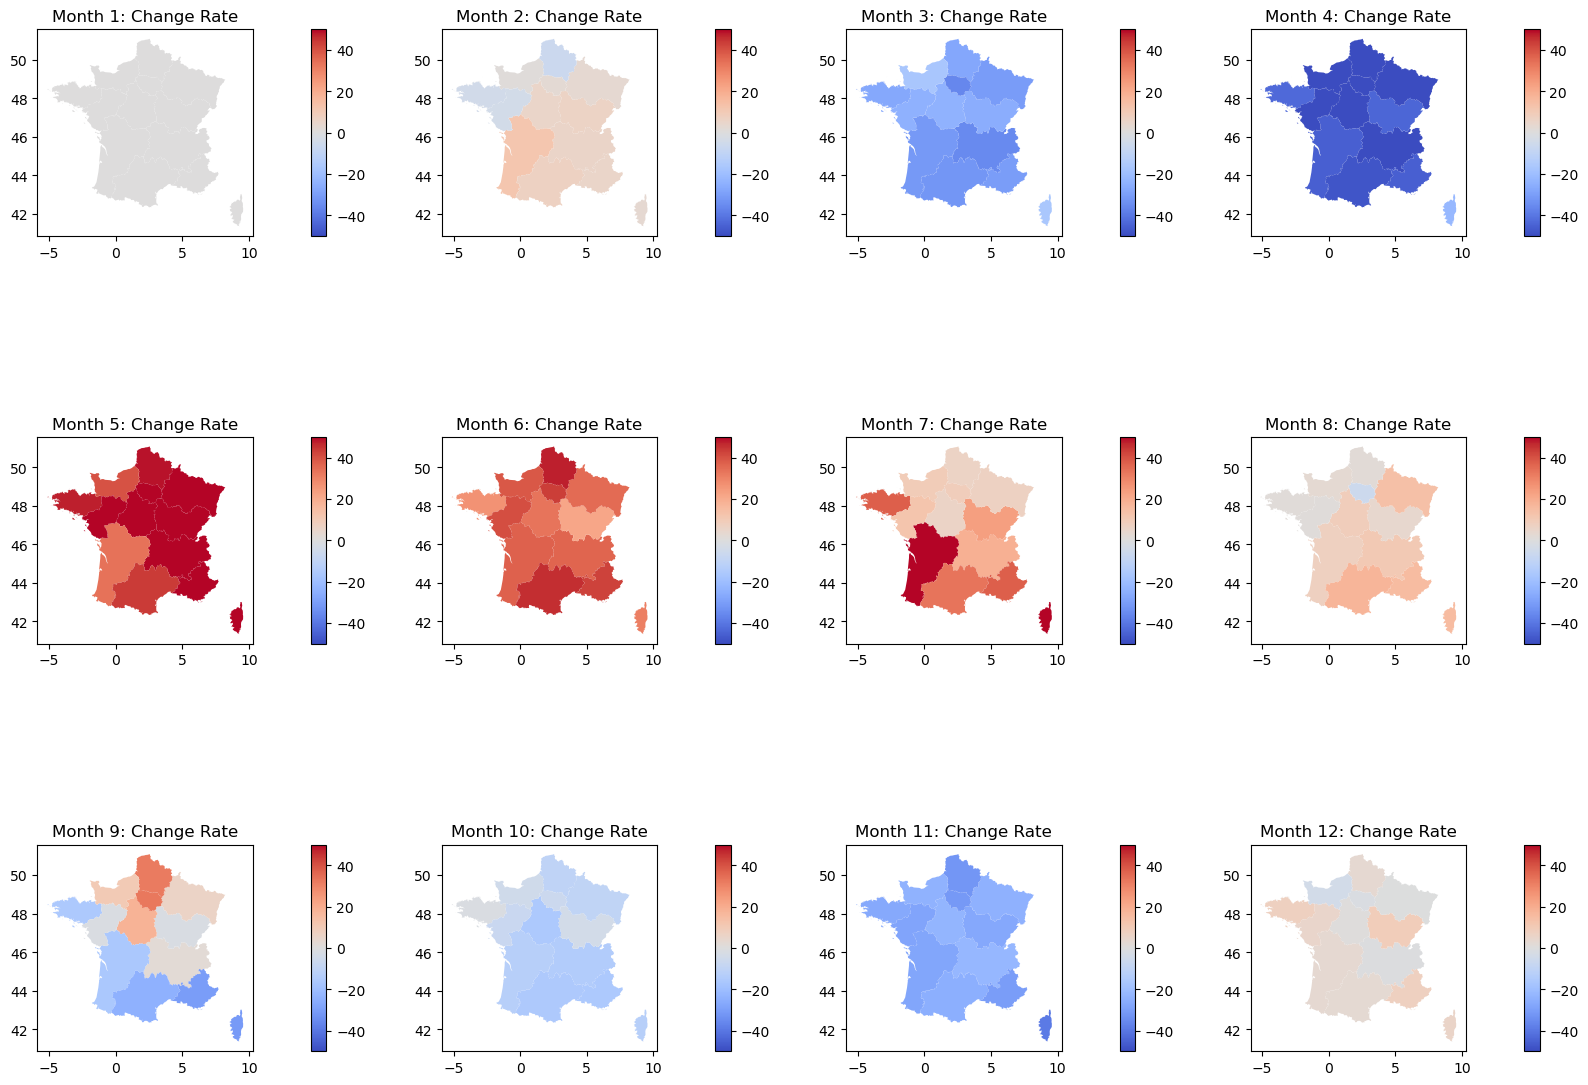

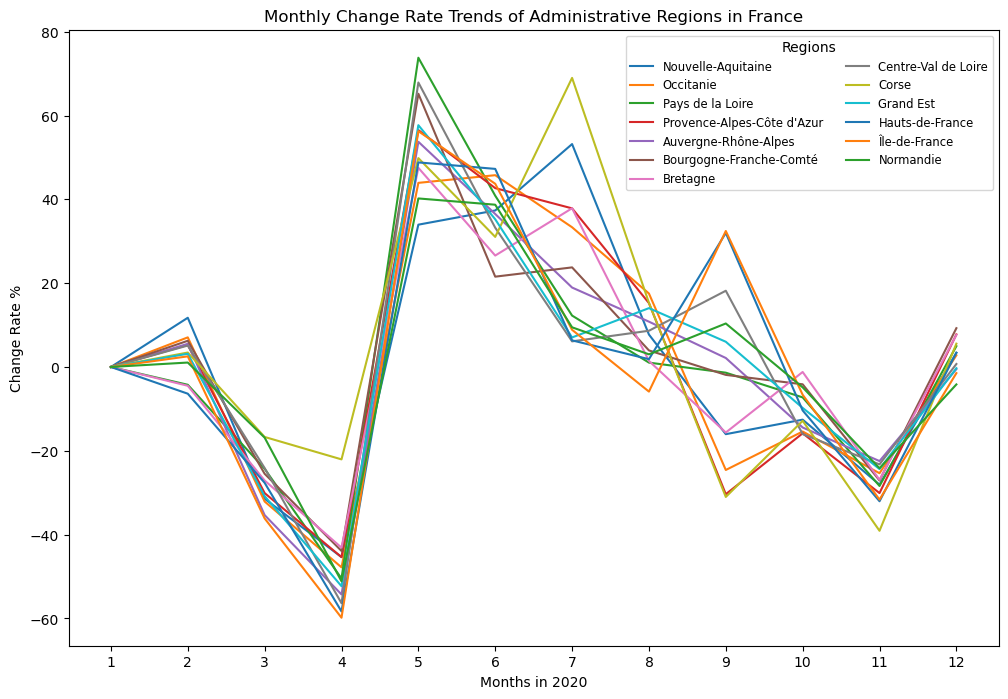



--------------- Done ---------------




In [132]:
direct_request_LLM_response = solution.get_direct_request_LLM_response(review=False)

# clear_output(wait=True)
# display(Code(solution.direct_request_code, language='python'))

code = solution.execute_complete_program(code=solution.direct_request_code, try_cnt=10)
# solution.direct_request_code = code
# display(Code(code, language='python'))
